In [1]:
using PyCall
using MXNet
using MLDataPattern
using Polyhedra
using CDDLib
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
push!(pyimport("sys")["path"], joinpath(pwd(), "py-mpc"))

PyObject ['/home/rdeits/locomotion/explorations/learning-mpc', '/home/rdeits/apps/FORCES_PRO', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python27.zip', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/plat-linux2', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/lib-tk', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/lib-old', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/lib-dynload', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/site-packages', '/home/rdeits/locomotion/explorations/learning-mpc/packages/v0.5/Conda/deps/usr/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/home/rdeits/locomotion/explorations/l

In [3]:
@pyimport pympc.geometry as geometry
@pyimport pympc.control as control
@pyimport pympc.dynamical_systems as dynamical_systems
@pyimport pympc.plot as mpcplot
@pyimport scipy.spatial as spatial

In [4]:
include("mpc.jl")

MPC

In [5]:
mass = 1.
l = 1.
g = 10.
N = 4
A = [0. 1.;
     g/l 0.]
B = [0 1/(mass*l^2.)]'
Δt = .1
pysys = dynamical_systems.DTLinearSystem[:from_continuous](A, B, Δt)

x_max = [pi/6, pi/20/(N*Δt)]
x_min = -x_max
u_max = [mass*g*l*pi/8.]
u_min = -u_max
times = 0:Δt:N*Δt

Q = eye(2)
R = eye(1)

X_bounds = geometry.Polytope[:from_bounds](reshape(x_min, 2, 1), reshape(x_max, 2, 1))[:assemble]()
U_bounds = geometry.Polytope[:from_bounds](reshape(u_min, 1, 1), reshape(u_max, 1, 1))[:assemble]()
controller = control.MPCController(pysys, N, "two", Q, R, X=X_bounds, U=U_bounds)

PyObject <pympc.control.MPCController instance at 0x7fdb0c422170>

In [6]:
explicit_controller = control.MPCExplicitController(controller[:condensed_program])

Computing critical region for the active set []
Computing critical region for the active set [8]
Computing critical region for the active set [9]
Computing critical region for the active set [15]
Computing critical region for the active set [17]
LICQ does not hold for the active set [1, 8]
    unfeasible critical region detected
Computing critical region for the active set [8, 15]
Computing critical region for the active set [8, 17]
LICQ does not hold for the active set [0, 9]
    unfeasible critical region detected
Computing critical region for the active set [9, 15]
Computing critical region for the active set [9, 17]
Computing critical region for the active set [1, 15]
Computing critical region for the active set [14, 15]
Computing critical region for the active set [0, 17]
Computing critical region for the active set [16, 17]
LICQ does not hold for the active set [1, 8, 15]
    unfeasible critical region detected
LICQ does not hold for the active set [1, 8, 17]
    unfeasible criti

PyObject <pympc.control.MPCExplicitController instance at 0x7fdb0c4221b8>

In [7]:
# mpcplot.state_partition(explicit_controller)
# mpcplot.plt[:show]()

# mpcplot.grouped_state_partition(explicit_controller)
# mpcplot.plt[:show]()

In [8]:
num_samples = 10000
X = fill(NaN, 2, num_samples)
U = fill(NaN, 1, num_samples)

for i in 1:num_samples
    while true
        x0 = x_min .+ rand(2) .* (x_max .- x_min)
        u_feedforward, cost = controller[:feedforward](x0)
        if !any(isnan.(u_feedforward))
            X[:, i] = x0
            U[:, i] = u_feedforward[1:length(u_max)]
            break
        end
    end
end

In [9]:
(X_train, U_train), (X_test, U_test) = splitobs((X, U), 0.6)
batch_size = 20
train_provider = mx.ArrayDataProvider(:x=>collect(X_train), :u_label=>collect(U_train), batch_size=batch_size)
test_provider = mx.ArrayDataProvider(:x=>collect(X_test), :u_label=>collect(U_test), batch_size=batch_size)

MXNet.mx.ArrayDataProvider(Array[
Float32[-0.176668 -0.0476521 … -0.460492 0.0309194; 0.179325 0.363815 … 0.1066 -0.377237]],Symbol[:x],Array[
Float32[0.435513 -0.180913 … 3.92699 0.449059]],Symbol[:u_label],20,4000,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(2,20)],MXNet.mx.NDArray[mx.NDArray{Float32}(1,20)])

In [20]:
mlp = @mx.chain mx.Variable(:x) => 
mx.FullyConnected(name=:fc1, num_hidden=4) =>
mx.Activation(name=:relu1, act_type=:relu) =>
mx.FullyConnected(name=:fc2, num_hidden=4) =>
mx.Activation(name=:relu2, act_type=:relu) => 
mx.FullyConnected(name=:fc3, num_hidden=4) => 
mx.Activation(name=:relu3, act_type=:relu) =>
mx.FullyConnected(name=:fc4, num_hidden=1) =>
mx.LinearRegressionOutput(name=:u)

# mlp = @mx.chain mx.Variable(:x) => 
# mx.FullyConnected(name=:fc1, num_hidden=1) =>|
# mx.Activation(name=:relu1, act_type=:relu) =>
# mx.FullyConnected(name=:fc2, num_hidden=1) =>
# mx.LinearRegressionOutput(name=:u)

model = mx.FeedForward(mlp, context=mx.cpu())
optimizer = mx.ADAM(lr=0.1)
mx.fit(model, optimizer, train_provider, n_epoch=20, verbosity=2, initializer=mx.UniformInitializer(1.0))

U_predict = mx.predict(model, test_provider)
err = U_predict .- U_test
sqrt(mean(err.^2))

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 0 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/020 ==========
INFO: == Epoch 002/020 ==========
INFO: == Epoch 003/020 ==========
INFO: == Epoch 004/020 ==========
INFO: == Epoch 005/020 ==========
INFO: == Epoch 006/020 ==========
INFO: == Epoch 007/020 ==========
INFO: == Epoch 008/020 ==========
INFO: == Epoch 009/020 ==========
INFO: == Epoch 010/020 ==========
INFO: == Epoch 011/020 ==========
INFO: == Epoch 012/020 ==========
INFO: == Epoch 013/020 ==========
INFO: == Epoch 014/020 ==========
INFO: == Epoch 015/020 ==========
INFO: == Epoch 016/020 ==========
INFO: == Epoch 017/020 ==========
INFO: == Epoch 018/020 ==========
INFO: == Epoch 019/020 ==========
INFO: == Epoch 020/020 ==========
INFO: Finish training on MXNet.mx.Context[CPU0]
INFO: TempSpace: Total 0 MB allocated on CPU0


0.10556009523859847

In [64]:
include("explicit_network.jl")

ExNet

In [65]:
net = ExNet.Net([
    Array{Float64}(model.arg_params[:fc1_weight]),
    Array{Float64}(model.arg_params[:fc2_weight]),
    Array{Float64}(model.arg_params[:fc3_weight]),
    Array{Float64}(model.arg_params[:fc4_weight]),
    ],
[
    Array{Float64}(model.arg_params[:fc1_bias]),
    Array{Float64}(model.arg_params[:fc2_bias]),
    Array{Float64}(model.arg_params[:fc3_bias]),
    Array{Float64}(model.arg_params[:fc4_bias]),
])

ExNet.remove_small_weights!(net)

for i in 1:100
    x = randn(2)
    p = mx.predict(model, mx.ArrayDataProvider(:x=>reshape(x, 2, 1)), verbosity=0)[1]
    f = ExNet.feedforward(net, x)[end]
    @assert p ≈ f
end

In [90]:
bounds = hrep(polyhedron(SimpleVRepresentation([x_min[1] x_min[2]; x_min[1] x_max[2]; x_max[1] x_max[2]; x_max[1] x_min[2]]), CDDLibrary()))
results = ExNet.explore(net, bounds, [0.0, 0])

Dict{BitArray{1},Polyhedra.SimpleHRepresentation{2,Float64}} with 7 entries:
  Bool[false,true,false,fa… => H-representation…
  Bool[false,true,false,fa… => H-representation…
  Bool[true,true,false,fal… => H-representation…
  Bool[false,false,true,fa… => H-representation…
  Bool[true,true,false,fal… => H-representation…
  Bool[false,false,true,fa… => H-representation…
  Bool[false,false,false,f… => H-representation…


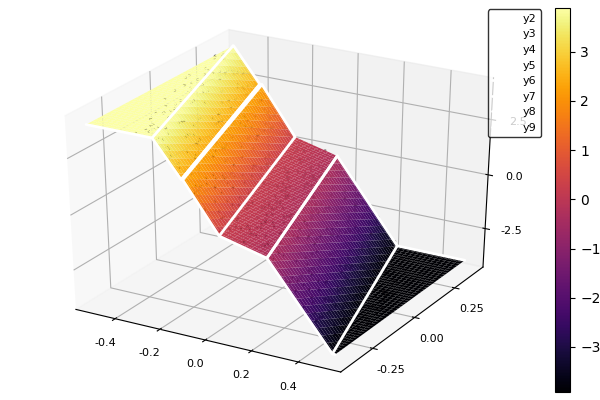

In [86]:
xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> mx.predict(model, mx.ArrayDataProvider(:x=>[x y]'), verbosity=0)[1])
nplot = 500
plot!(plt, [X[1, i] for i in 1:nplot], [X[2, i] for i in 1:nplot], [U[1, i] for i in 1:nplot], markershape=:circle, markersize=1, line=nothing)
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary()))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt, x, y, [ExNet.feedforward(net, [x[i], y[i]])[end] for i in eachindex(x)], linecolor=:white, linewidth=2)
    end
end
plt

In [69]:
gui()


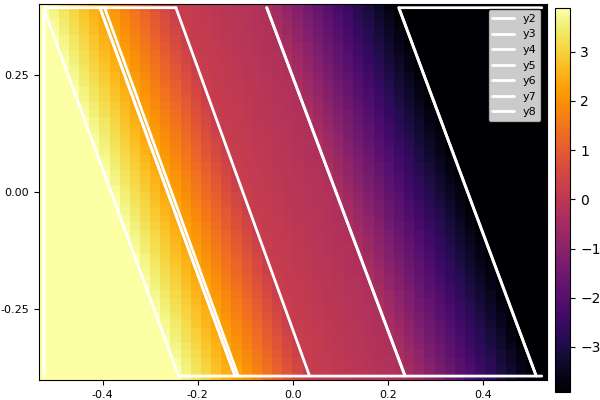

In [88]:
plt = heatmap(xx, yy, (x, y) -> mx.predict(model, mx.ArrayDataProvider(:x=>[x y]'), verbosity=0)[1])
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary(:exact)))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
        plot!(plt, x, y, linecolor=:white, linewidth=2)
    end
end
plt

In [89]:
mpcplot.grouped_state_partition(explicit_controller)
ax = mpcplot.plt[:gca]()
for (i, (state, p)) in enumerate(results)
    V = SimpleVRepresentation(vrep(polyhedron(p, CDDLibrary(:exact)))).V
    if !isempty(V)
        hull = spatial.ConvexHull(V)
        points = [hull[:points][i + 1, :] for i in hull[:vertices]]
        x = [p[1] for p in points]
        y = [p[2] for p in points]
       ax[:plot](x, y, "w-", linewidth=2)
    end
end
mpcplot.plt[:xlim]([x_min[1], x_max[1]])
mpcplot.plt[:ylim]([x_min[2], x_max[2]])
mpcplot.plt[:show]()

Critical regions grouped in  9  sets.
